In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
sns.set_theme()
register_matplotlib_converters()

In [2]:
df = pd.read_csv("historical-daily-weather\Prepped data.csv", index_col="date")
df.head()

,daily_rainfall_total,mean_temperature,maximum_temperature,minimum_temperature,mean_wind_speed,max_wind_speed,temperature_range
date,,,,,,,
2009-01-24,0.0,26.80,31.4,24.4,11.7,38.2,7.0
2009-01-25,0.8,25.90,27.8,24.4,12.7,38.2,3.4
2009-01-26,0.0,25.90,29.6,23.7,12.4,42.5,5.9
2009-01-27,0.0,26.25,30.2,23.7,10.4,38.9,6.5
2009-01-28,0.0,26.60,31.9,23.7,10.3,32.4,8.2


In [3]:
df.index = pd.to_datetime(df.index, infer_datetime_format=True)
df.head()

,daily_rainfall_total,mean_temperature,maximum_temperature,minimum_temperature,mean_wind_speed,max_wind_speed,temperature_range
date,,,,,,,
2009-01-24,0.0,26.80,31.4,24.4,11.7,38.2,7.0
2009-01-25,0.8,25.90,27.8,24.4,12.7,38.2,3.4
2009-01-26,0.0,25.90,29.6,23.7,12.4,42.5,5.9
2009-01-27,0.0,26.25,30.2,23.7,10.4,38.9,6.5
2009-01-28,0.0,26.60,31.9,23.7,10.3,32.4,8.2


In [4]:
plt.rc("figure",figsize=(16, 12))
plt.rc("font",size=13)

#Statistical Methods

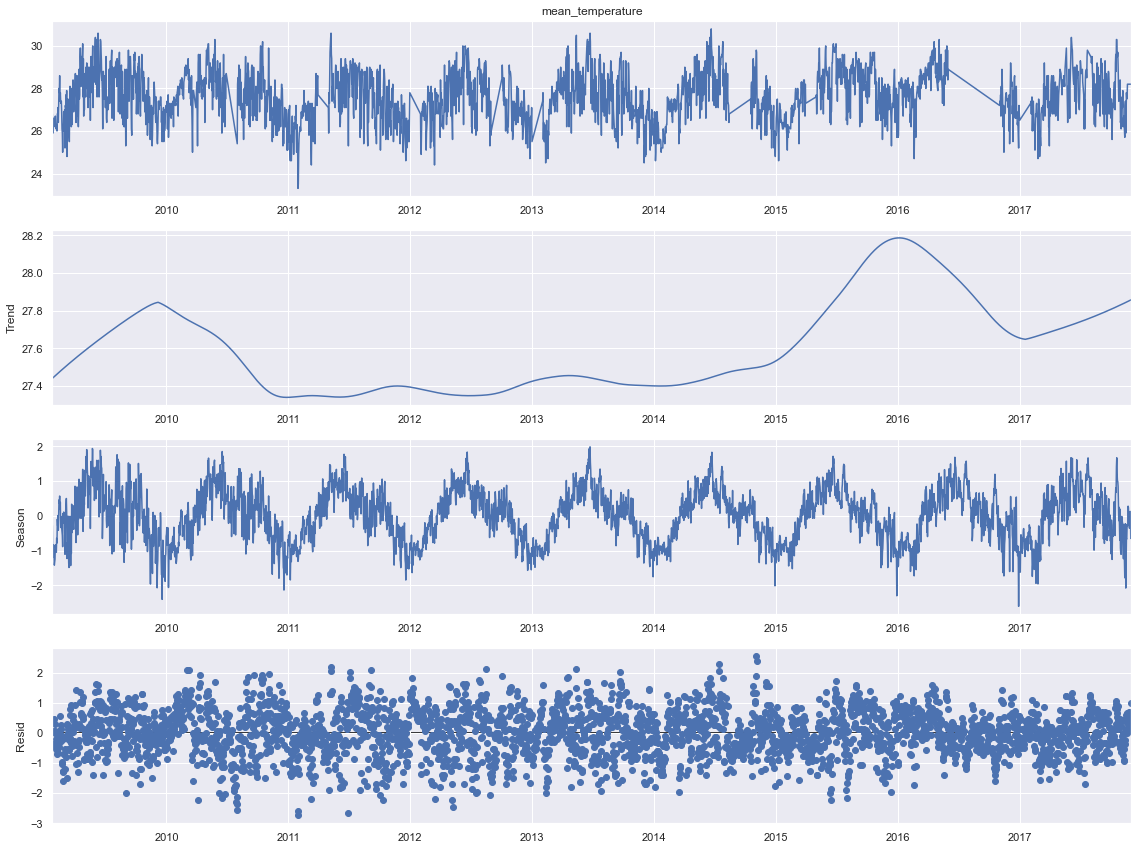

In [5]:
#Daily time series
#Seasonal-Trend decomposition with LOESS
from statsmodels.tsa.seasonal import STL
stl = STL(df["mean_temperature"],period=365,seasonal=11)
res = stl.fit()
fig = res.plot()

Slight upward trend in mean temperatures as observed earlier with peaks at the end of 2009 and 2015. Obvious seasonality with peaks in the middle of the year and troughs at the start/end of the year.

In [6]:
#Split train test data (80-20)
train = df.loc[:'2016-05-31']
test = df.loc['2016-06-01':]

#Holt-Winters Exponential Smoothing (HWES)

c:\Users\waiho\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\waiho\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


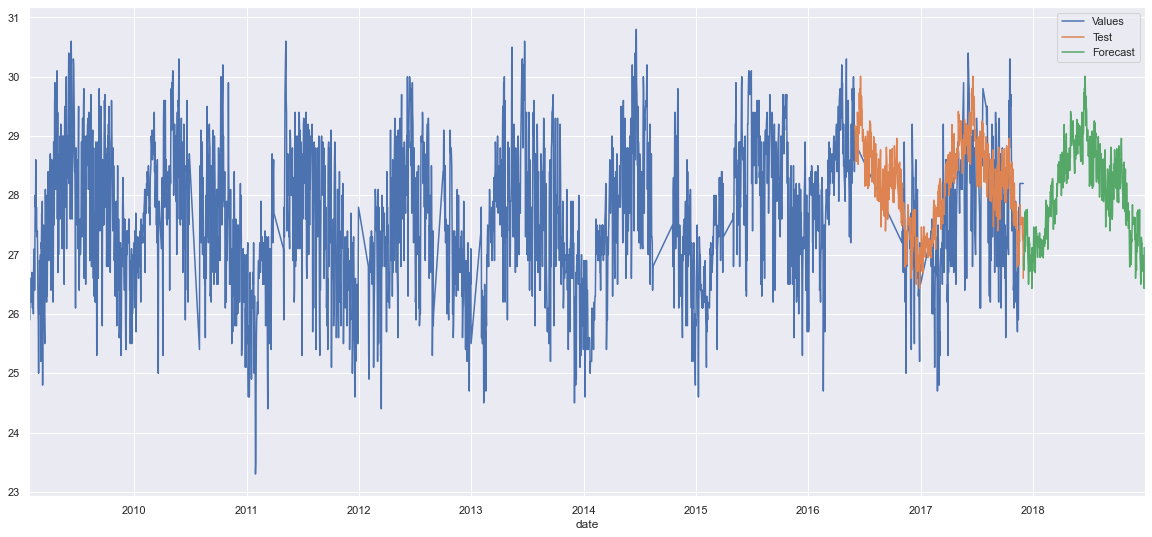

Mean absolute error: 0.7294548714374061
Root mean squared error: 0.951163708477206


<Figure size 1152x864 with 0 Axes>

In [7]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing   

# train model and predict
hwmodel = ExponentialSmoothing(train["mean_temperature"], seasonal='mul', seasonal_periods=365).fit()
pred_test = hwmodel.predict(start='2016-06-01', end='2017-11-30')
pred_forecast = hwmodel.predict(start='2017-12-01', end='2018-12-31')

# plot data and prediction
df["mean_temperature"].plot(figsize=(20,9), label='Values')
pred_test.plot(label='Test')
pred_forecast.plot(label='Forecast')
plt.legend()
plt.show()
plt.savefig('figure.png')

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print(f"Mean absolute error: {mean_absolute_error(test['mean_temperature'],pred_test)}")
print(f"Root mean squared error: {mean_squared_error(test['mean_temperature'],pred_test,squared=False)}")

In [8]:
#Monthly aggregate
df_m = df.resample('MS').mean()
df_m.head()

,daily_rainfall_total,mean_temperature,maximum_temperature,minimum_temperature,mean_wind_speed,max_wind_speed,temperature_range
date,,,,,,,
2009-01-01,0.100000,26.331250,30.212500,24.100000,11.225000,37.100000,6.112500
2009-02-01,5.285714,26.767857,31.442857,24.260714,9.564286,35.842857,7.182143
2009-03-01,11.435484,26.938710,32.117742,24.000000,7.112903,35.674194,8.117742
2009-04-01,4.960000,28.120000,32.196667,25.066667,7.363333,35.086667,7.130000
2009-05-01,6.632258,28.483871,32.590323,25.093548,7.451613,36.103226,7.496774


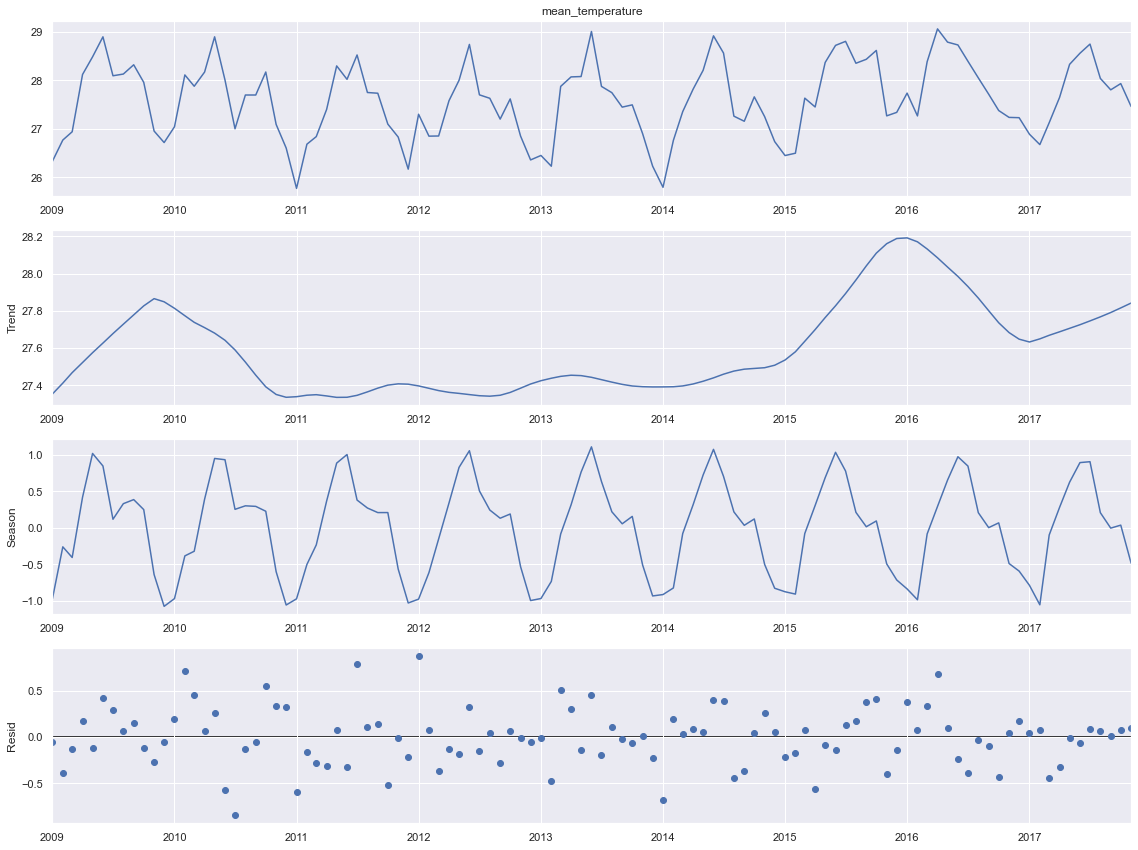

In [9]:
stl = STL(df_m["mean_temperature"],period=12,seasonal=11)
res = stl.fit()
fig = res.plot()

General increasing trend in mean temperatures with spikes from 2009 to 2010 and 2015 to 2016. Looking at the seasonsality, mean temperatures peak in May and June and are lowest in January and February.

In [10]:
#Split train test data
train_m = df_m.loc[:'2016-06-01']
test_m = df_m.loc['2016-07-01':]

#Holt-Winters Exponential Smoothing (HWES)

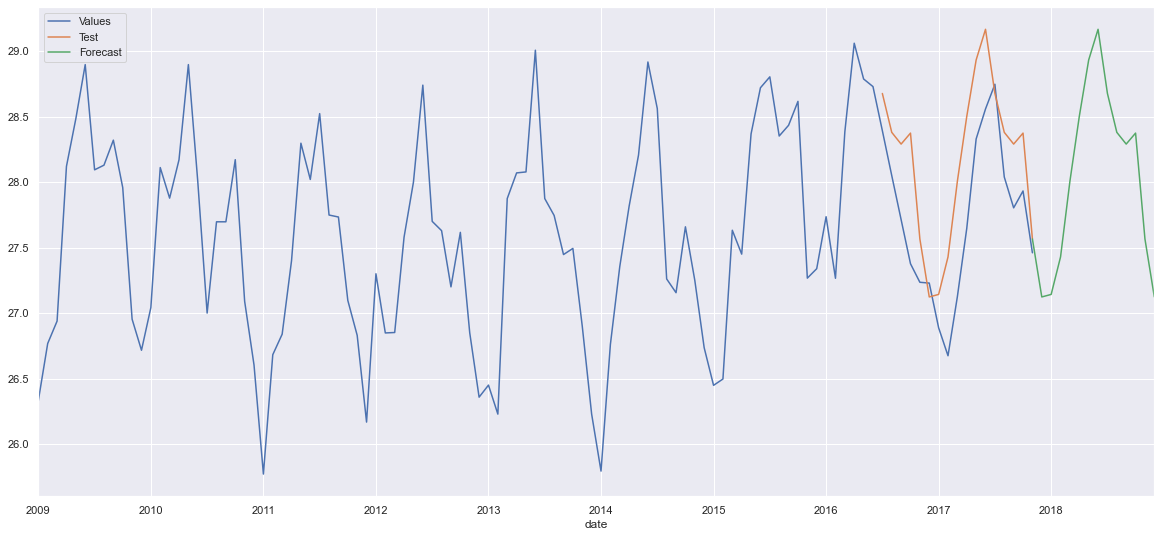

Mean absolute error: 0.4720459238247769
Root mean squared error: 0.5463534143293616


<Figure size 1152x864 with 0 Axes>

In [11]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing   

# train model and predict
hwmodel = ExponentialSmoothing(train_m["mean_temperature"], seasonal='mul', seasonal_periods=12).fit()
pred_test = hwmodel.predict(start='2016-07-01', end='2017-11-01')
pred_forecast = hwmodel.predict(start='2017-11-01', end='2018-12-01')

# plot data and prediction
df_m["mean_temperature"].plot(figsize=(20,9), label='Values')
pred_test.plot(label='Test')
pred_forecast.plot(label='Forecast')
plt.legend()
plt.show()
plt.savefig('figure.png')

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print(f"Mean absolute error: {mean_absolute_error(test_m['mean_temperature'],pred_test)}")
print(f"Root mean squared error: {mean_squared_error(test_m['mean_temperature'],pred_test,squared=False)}")

#Seasonal Autoregressive Integrated Moving Average (SARIMA)

In [12]:
#Function to perform Augmented Dickey Fuller test to see if time series data is stationary or not (ARIMA requires time series data to be stationary)
from statsmodels.tsa.stattools import adfuller

adftest = adfuller(df_m['mean_temperature'], autolag='AIC')
dfoutput = pd.Series(adftest[0:4], index=['Test statistic','p-value','#Lags used','Number of observations'])
for key,value in adftest[4].items():
    dfoutput['Critical value (%s)'%key] = value
print (dfoutput)

Test statistic            -1.481153
p-value                    0.542813
#Lags used                11.000000
Number of observations    95.000000
Critical value (1%)       -3.501137
Critical value (5%)       -2.892480
Critical value (10%)      -2.583275
dtype: float64


p-value > significance level of 0.05 - do not reject null hypothesis that time series is non-stationary and take time series to be non-stationary

In [13]:
adftest = adfuller(df_m['mean_temperature'].diff().dropna(), autolag='AIC')
dfoutput = pd.Series(adftest[0:4], index=['Test statistic','p-value','#Lags used','Number of observations'])
for key,value in adftest[4].items():
    dfoutput['Critical value (%s)'%key] = value
print (dfoutput)

Test statistic           -7.449705e+00
p-value                   5.713411e-11
#Lags used                1.000000e+01
Number of observations    9.500000e+01
Critical value (1%)      -3.501137e+00
Critical value (5%)      -2.892480e+00
Critical value (10%)     -2.583275e+00
dtype: float64


1st order differencing makes time series stationary

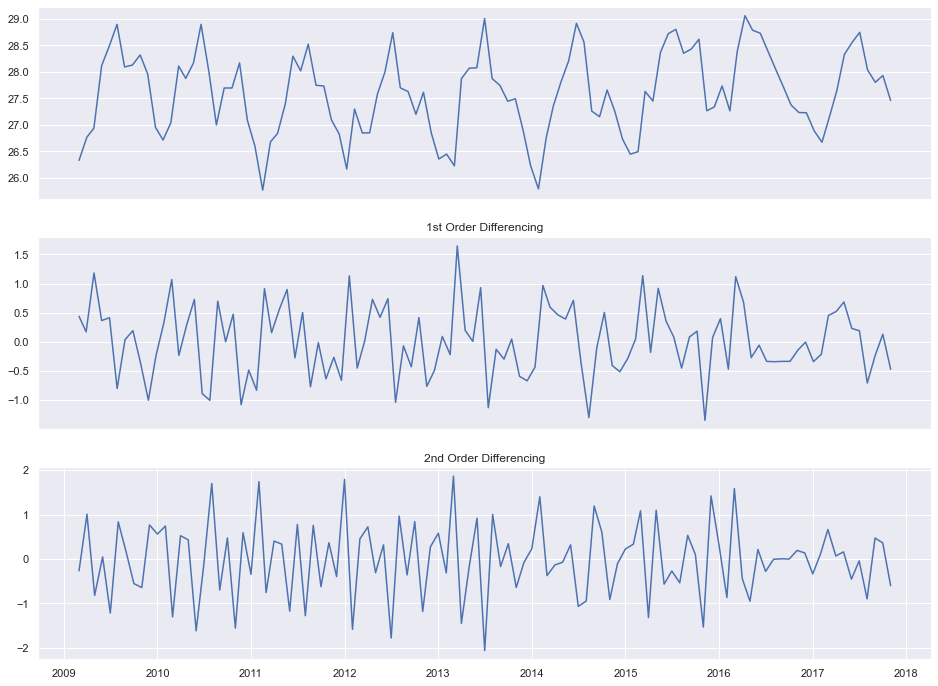

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df_m['mean_temperature']); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df_m['mean_temperature'].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df_m['mean_temperature'].diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

1st order differencing makes time series stationary and 2nd order differencing introduces more noise to the time series data

c:\Users\waiho\anaconda3\envs\myenv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


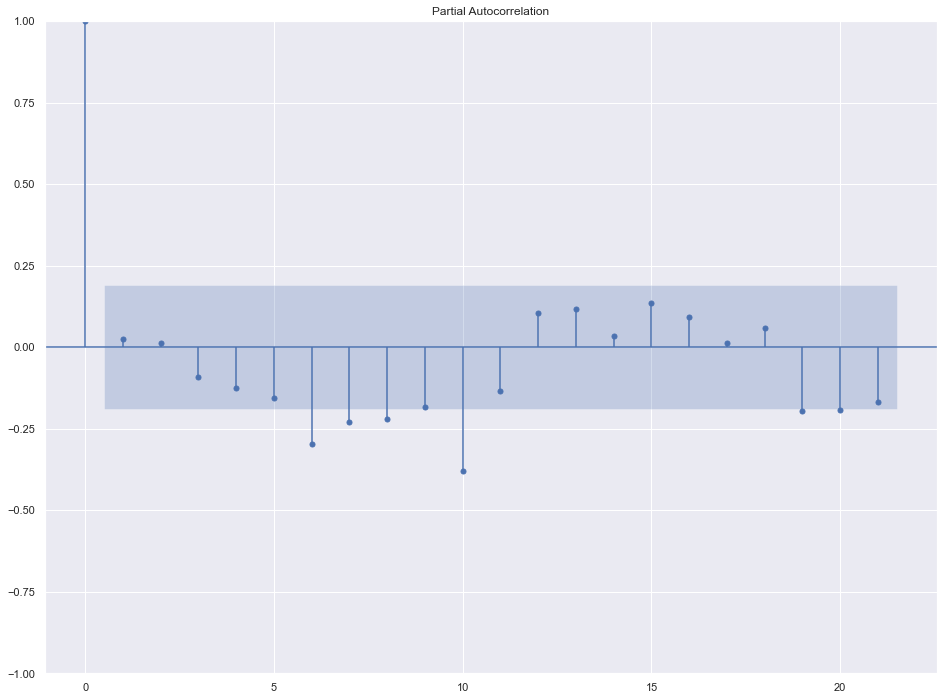

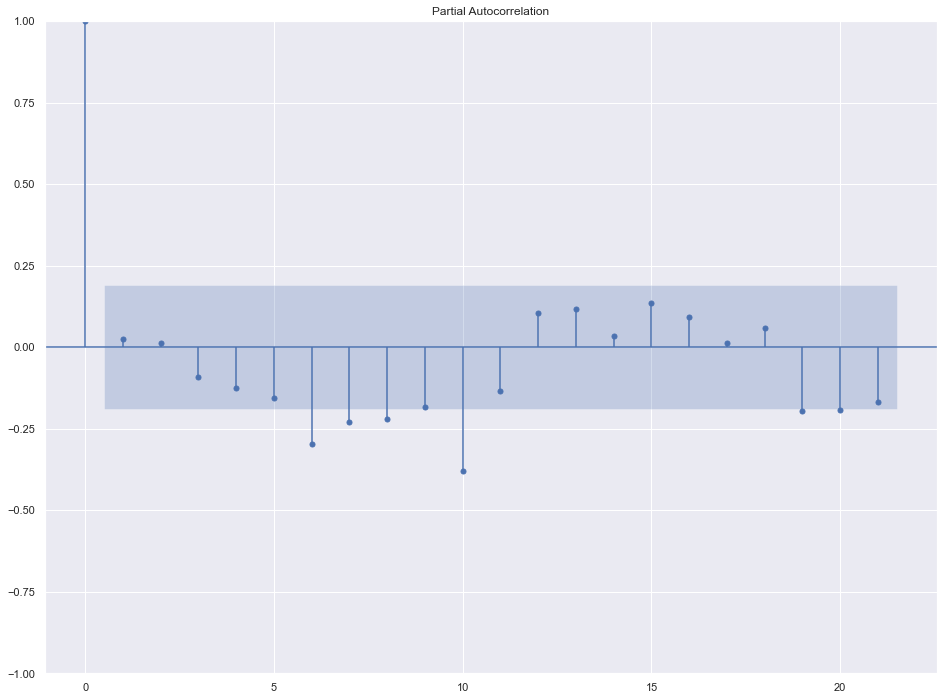

In [15]:
#PACF plot to determine order of AR term (p)
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_m["mean_temperature"].diff().dropna())

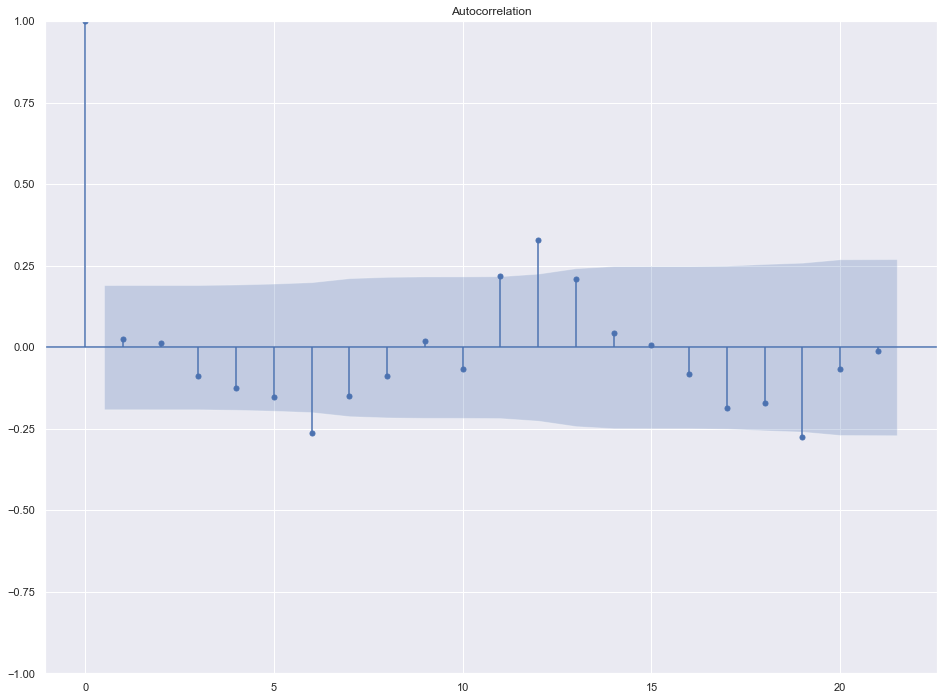

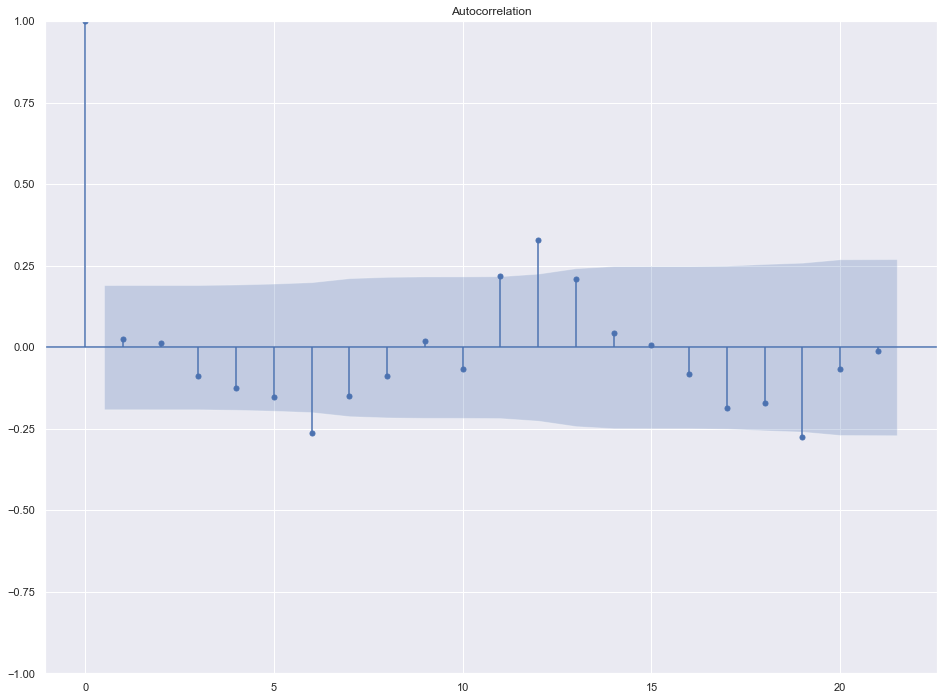

In [16]:
#ACF plot to determine order of MA term (q)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_m['mean_temperature'].diff().dropna())

In [17]:
#Use auto_arima to find the optimal model
from pmdarima.arima import auto_arima
auto_arima(df_m['mean_temperature'],start_p=0,start_q=0,max_p=10,max_q=10,start_P=0,start_Q=0,max_P=10,max_D=2,max_Q=10,d=1,m=12,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=198.692, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=187.175, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=192.842, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=196.725, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=200.630, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=179.013, Time=0.12 sec
 ARIMA(1,1,0)(3,0,0)[12] intercept   : AIC=173.763, Time=0.33 sec
 ARIMA(1,1,0)(4,0,0)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(1,1,0)(3,0,1)[12] intercept   : AIC=174.862, Time=0.56 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=173.798, Time=0.27 sec
 ARIMA(1,1,0)(4,0,1)[12] intercept   : AIC=176.782, Time=2.08 sec
 ARIMA(0,1,0)(3,0,0)[12] intercept   : AIC=178.954, Time=0.28 sec
 ARIMA(2,1,0)(3,0,0)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(1,1,1)(3,0,0)[12] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,1,1)(3,0,0)[12] intercept   : AIC=16

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

c:\Users\waiho\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\waiho\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\waiho\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


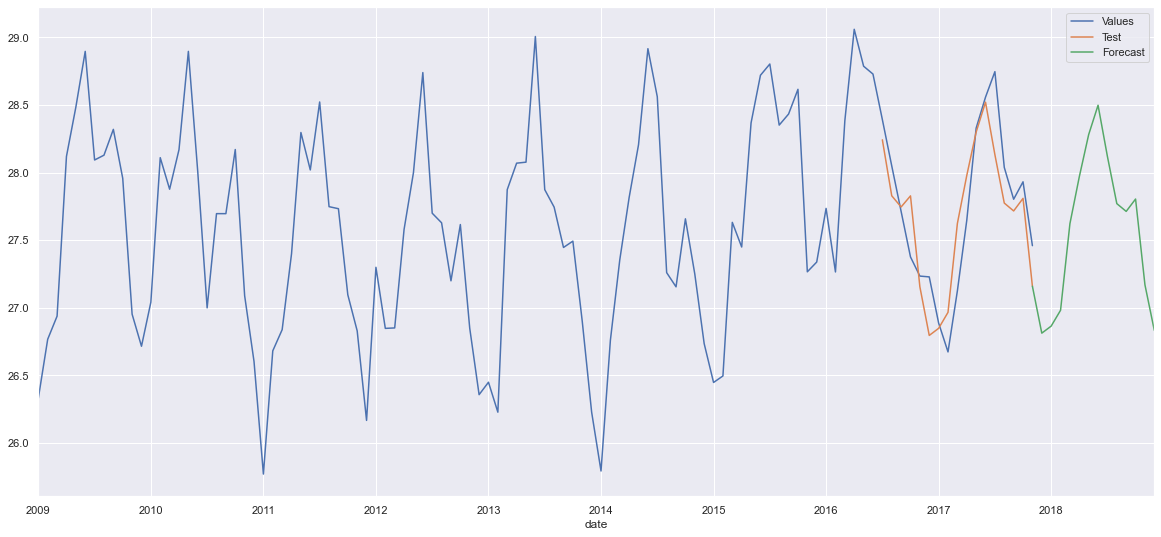

Mean absolute error: 0.2342953586273681
Root mean squared error: 0.2947873272498163


<Figure size 1152x864 with 0 Axes>

In [18]:
from statsmodels.tsa.arima.model import ARIMA   

# train model and predict
# use optimal order and seasonal order determined earlier
arimamodel = ARIMA(train_m["mean_temperature"],order=(2,1,2),seasonal_order=(1,0,1,12)).fit()
pred_test = arimamodel.predict(start='2016-07-01', end='2017-11-01')
pred_forecast = arimamodel.predict(start='2017-11-01', end='2018-12-01')

# plot data and prediction
df_m["mean_temperature"].plot(figsize=(20,9), label='Values')
pred_test.plot(label='Test')
pred_forecast.plot(label='Forecast')
plt.legend()
plt.show()
plt.savefig('figure.png')

print(f"Mean absolute error: {mean_absolute_error(test_m['mean_temperature'],pred_test)}")
print(f"Root mean squared error: {mean_squared_error(test_m['mean_temperature'],pred_test,squared=False)}")

#Long Short-Term Memory (LSTM)

In [19]:
import tensorflow as tf
import IPython
import IPython.display
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [20]:
#Daily time series
#Split data into train, val and test (60-20-20)
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[:'2014-05-31']
val_df = df['2014-06-01':'2016-02-29']
test_df = df['2016-03-01':]

num_features = df.shape[1]

In [21]:
#Standardisation of data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [22]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [23]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [24]:
#Window: Predict mean temperature for 1 day given the data from previous 30 days
OUT_STEPS = 1

window_d = WindowGenerator(input_width=30, label_width=OUT_STEPS, shift=OUT_STEPS,
                     label_columns=['mean_temperature'])

window_d

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['mean_temperature']

In [25]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [26]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [27]:
MAX_EPOCHS = 300

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [28]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [29]:
print('Input shape:', window_d.example[0].shape)
print('Output shape:', multi_lstm_model(window_d.example[0]).shape)

Input shape: (32, 30, 7)
Output shape: (32, 1, 7)


In [30]:
history = compile_and_fit(multi_lstm_model, window_d)

Epoch 1/300
61/61 [==============================] - 2s 9ms/step - loss: 0.8018 - mean_absolute_error: 0.7165 - val_loss: 0.5164 - val_mean_absolute_error: 0.5898
Epoch 2/300
61/61 [==============================] - 0s 5ms/step - loss: 0.6099 - mean_absolute_error: 0.6261 - val_loss: 0.4544 - val_mean_absolute_error: 0.5413
Epoch 3/300
61/61 [==============================] - 0s 5ms/step - loss: 0.5667 - mean_absolute_error: 0.6004 - val_loss: 0.4251 - val_mean_absolute_error: 0.5178
Epoch 4/300
61/61 [==============================] - 0s 5ms/step - loss: 0.5384 - mean_absolute_error: 0.5834 - val_loss: 0.4098 - val_mean_absolute_error: 0.5041
Epoch 5/300
61/61 [==============================] - 0s 5ms/step - loss: 0.5205 - mean_absolute_error: 0.5707 - val_loss: 0.4012 - val_mean_absolute_error: 0.4998
Epoch 6/300
61/61 [==============================] - 0s 5ms/step - loss: 0.5068 - mean_absolute_error: 0.5603 - val_loss: 0.4057 - val_mean_absolute_error: 0.5062
Epoch 7/300
61/61 [===

In [31]:
print(multi_lstm_model.evaluate(window_d.val))
print(multi_lstm_model.evaluate(window_d.test))

20/20 [==============================] - 0s 1ms/step - loss: 0.4097 - mean_absolute_error: 0.5088
[0.40973100066185, 0.5087908506393433]
20/20 [==============================] - 0s 1ms/step - loss: 0.3597 - mean_absolute_error: 0.4547
[0.35968077182769775, 0.45473313331604004]


In [32]:
def plot(self, model=None, plot_col='mean_temperature', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

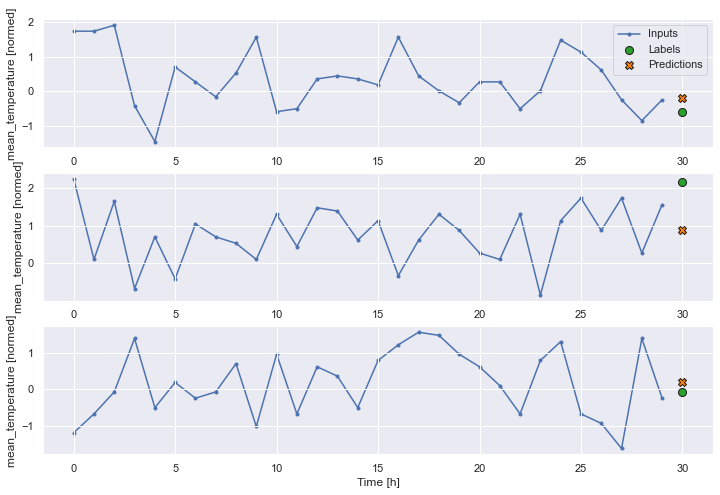

In [33]:
window_d.plot(multi_lstm_model)

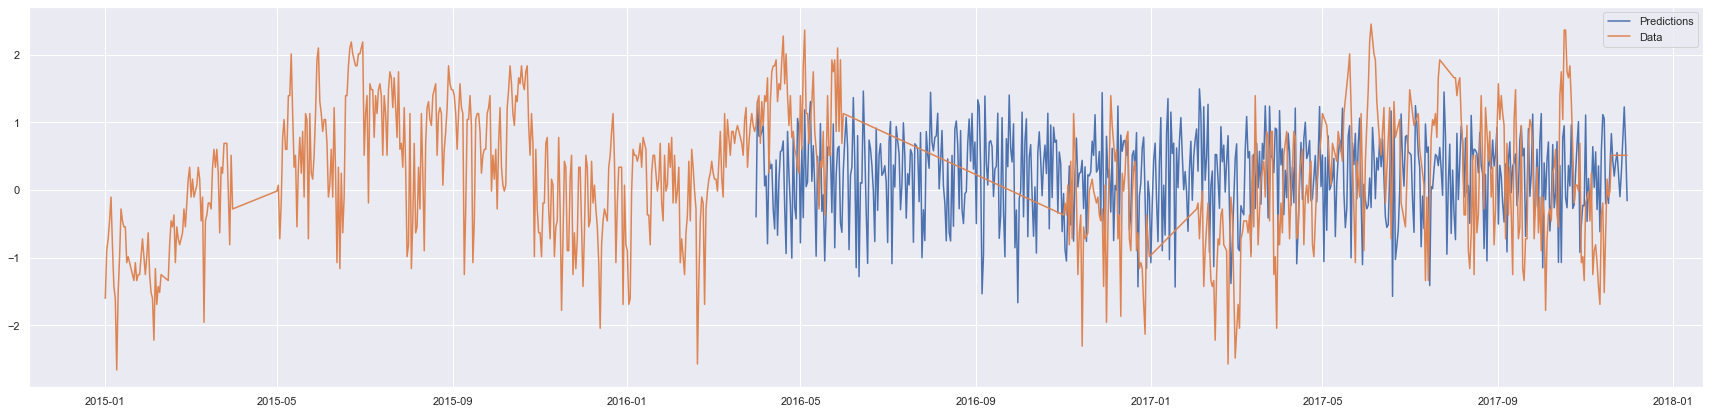

In [34]:
st_labels = (df['mean_temperature'] - df['mean_temperature'].mean())/df['mean_temperature'].std()
pred = multi_lstm_model.predict(window_d.test)[:,:,0]

plt.figure(figsize=(30,7))
plt.plot(test_df.index[30:],pred,label='Predictions')
plt.plot(st_labels['2015-01-01':],label='Data')
plt.legend()

In [35]:
#Monthly time series
#Split data into train, val and test (60-20-20)
column_indices = {name: i for i, name in enumerate(df_m.columns)}

n = len(df_m)
train_df = df_m[:'2014-05-01']
val_df = df_m['2014-06-01':'2016-02-01']
test_df = df_m['2016-03-01':]

num_features = df_m.shape[1]

In [36]:
#Standardisation of data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [37]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [38]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [39]:
#Window: Predict mean temperature for 1 month given the data from previous 5 months
OUT_STEPS = 1

window_m = WindowGenerator(input_width=5, label_width=OUT_STEPS, shift=OUT_STEPS,
                     label_columns=['mean_temperature'])

window_m

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['mean_temperature']

In [40]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [41]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [42]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [43]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [44]:
history = compile_and_fit(multi_lstm_model, window_m)

Epoch 1/100
2/2 [==============================] - 1s 249ms/step - loss: 0.9682 - mean_absolute_error: 0.8236 - val_loss: 1.0392 - val_mean_absolute_error: 0.8402
Epoch 2/100
2/2 [==============================] - 0s 35ms/step - loss: 0.9651 - mean_absolute_error: 0.8221 - val_loss: 1.0333 - val_mean_absolute_error: 0.8391
Epoch 3/100
2/2 [==============================] - 0s 34ms/step - loss: 0.9614 - mean_absolute_error: 0.8202 - val_loss: 1.0271 - val_mean_absolute_error: 0.8378
Epoch 4/100
2/2 [==============================] - 0s 36ms/step - loss: 0.9574 - mean_absolute_error: 0.8182 - val_loss: 1.0207 - val_mean_absolute_error: 0.8363
Epoch 5/100
2/2 [==============================] - 0s 36ms/step - loss: 0.9529 - mean_absolute_error: 0.8160 - val_loss: 1.0136 - val_mean_absolute_error: 0.8347
Epoch 6/100
2/2 [==============================] - 0s 35ms/step - loss: 0.9477 - mean_absolute_error: 0.8136 - val_loss: 1.0063 - val_mean_absolute_error: 0.8329
Epoch 7/100
2/2 [==========

In [45]:
print(multi_lstm_model.evaluate(window_m.val))
print(multi_lstm_model.evaluate(window_m.test))

1/1 [==============================] - 0s 29ms/step - loss: 0.3494 - mean_absolute_error: 0.5343
[0.3493964970111847, 0.5343177318572998]
1/1 [==============================] - 0s 33ms/step - loss: 0.0934 - mean_absolute_error: 0.2432
[0.09342854470014572, 0.24323770403862]


In [46]:
def plot(self, model=None, plot_col='mean_temperature', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

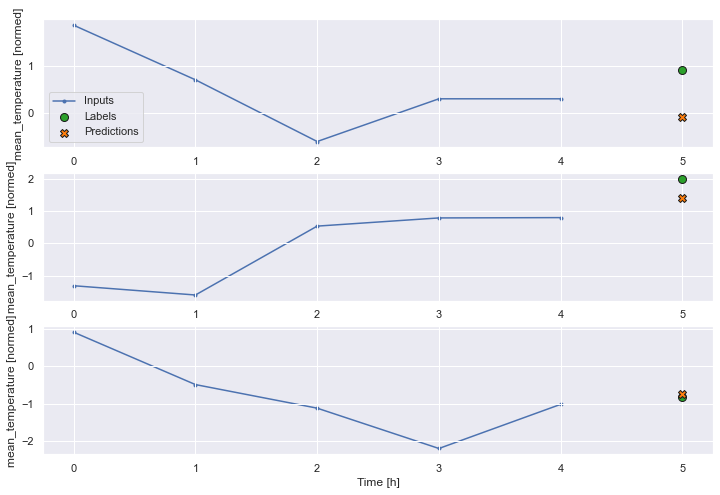

In [47]:
window_m.plot(multi_lstm_model)

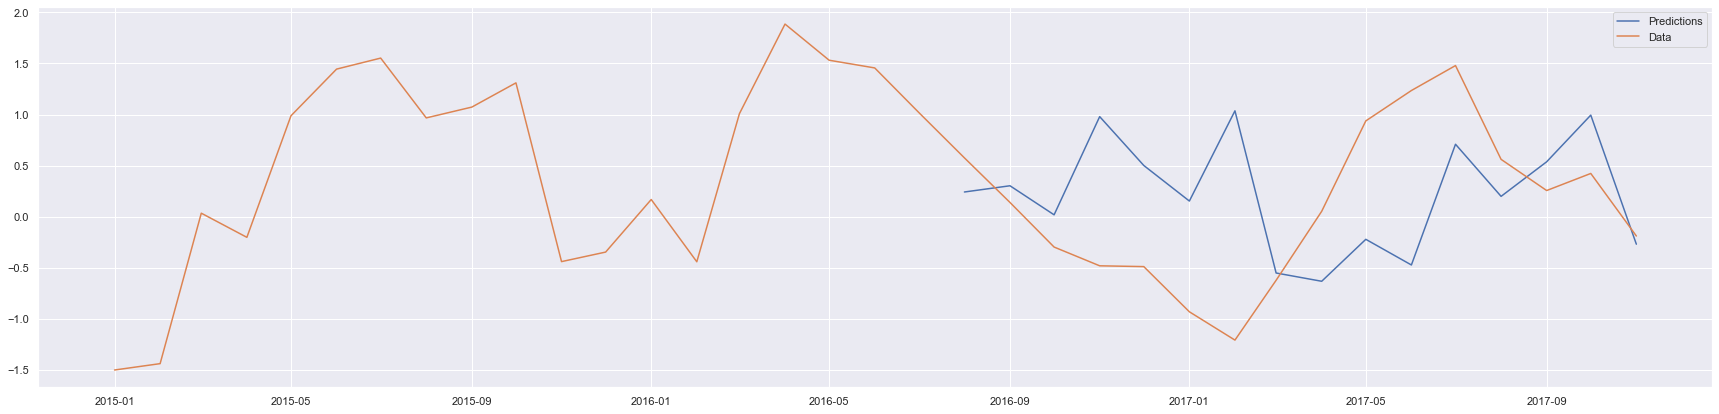

In [48]:
st_labels = (df_m['mean_temperature'] - df_m['mean_temperature'].mean())/df_m['mean_temperature'].std()
pred = multi_lstm_model.predict(window_m.test)[:,:,0]

plt.figure(figsize=(30,7))
plt.plot(test_df.index[5:],pred,label='Predictions')
plt.plot(st_labels['2015-01-01':],label='Data')
plt.legend()
